In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score
import re
from scipy import interpolate
# 図のスタイル設定
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 5)

print("ライブラリ読み込み完了")
import japanize_matplotlib


ライブラリ読み込み完了


In [30]:
def make_time_row(df):
    df["time"] = np.arange(0, len(df)) / 100
    return df
def get_first_trigger_segment(df, trigger_col="value", trigger_value=2):
    """
    最初のトリガー値(trigger_value)が立ってから
    次のトリガーが立つ直前までの区間を返す。
    """

    trigger_idx = df.index[df[trigger_col] >= trigger_value].tolist()
    print(trigger_idx)


    if len(trigger_idx) == 0:
        return None  # トリガーが無い

    # 最初のトリガー開始
    start = trigger_idx[0]

    # 次のトリガーがあるか？
    # if len(trigger_idx) >= 2:
        # end = trigger_idx[-1]
    # else:
    end = df.index[-1]  # トリガーが1回だけの場合、最後まで
    
    print(start,end)

    return df.loc[start:end].reset_index(drop=True)

def fix_columns(df):
    cleaned = [re.sub(r'\.\d+$', '', c) for c in df.columns]  # .1 や .2 を除去
    new_cols = []
    seen = {}

    for col in cleaned:
        if col not in seen:
            seen[col] = 1
            new_cols.append(f"{col}_1")
        else:
            seen[col] += 1
            new_cols.append(f"{col}_{seen[col]}")

    df.columns = new_cols
    return df

def estimate_sampling_rate(df):
    t = df['time'].values
    # 時刻差分（dt）を計算
    dt = np.diff(t)
    # 正の値のみ（たまに逆順やゼロが混ざるため）
    dt = dt[dt > 0]
    # メジアンをサンプリング周期とする
    dt_med = np.median(dt)
    # sampling rate [Hz]
    fs = 1.0 / dt_med
    return fs, dt_med


In [31]:
data_info = pd.read_excel(r"C:\Users\youli\Desktop\code\20251118_COPモドキ\info.xlsx")
data_info

,sub,seat,cop,pedal,steer,label
0,A,C:\Users\youli\Desktop\code\20251118_COPモドキ\ex...,C:\Users\youli\Desktop\code\20251118_COPモドキ\ex...,C:\Users\youli\Desktop\code\20251118_COPモドキ\ex...,C:\Users\youli\Desktop\code\20251118_COPモドキ\ex...,2F
1,B,C:\Users\youli\Desktop\code\20251118_COPモドキ\ex...,C:\Users\youli\Desktop\code\20251118_COPモドキ\ex...,C:\Users\youli\Desktop\code\20251118_COPモドキ\ex...,C:\Users\youli\Desktop\code\20251118_COPモドキ\ex...,2F
2,A,C:\Users\youli\Desktop\code\20251118_COPモドキ\ex...,C:\Users\youli\Desktop\code\20251118_COPモドキ\ex...,C:\Users\youli\Desktop\code\20251118_COPモドキ\ex...,C:\Users\youli\Desktop\code\20251118_COPモドキ\ex...,3F


[436, 437, 438, 439, 440, 441, 442, 443, 444, 445, 1592, 1593, 1594, 1595, 1596, 1597, 1598, 1599, 1600, 1601, 25268, 25269, 25270, 25271, 25272, 25273, 25274, 25275, 25276, 25277, 25278]
436 30000


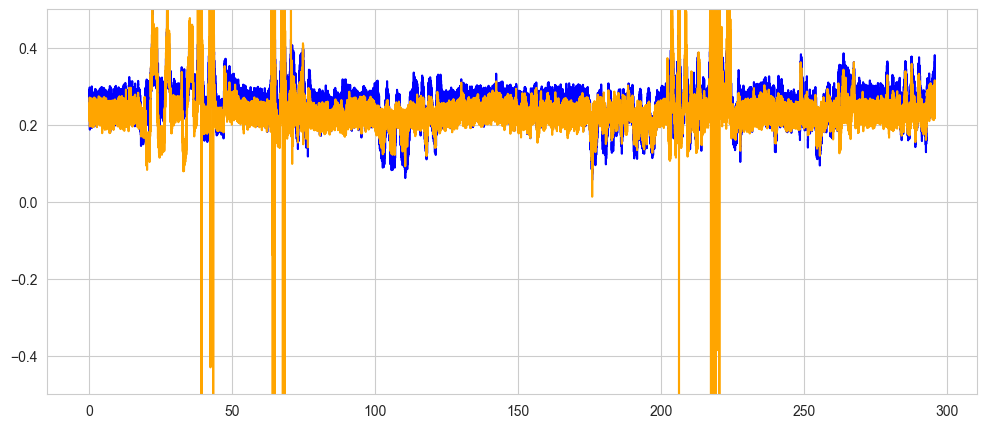

Sampling rate: 41.66666666666509 Hz


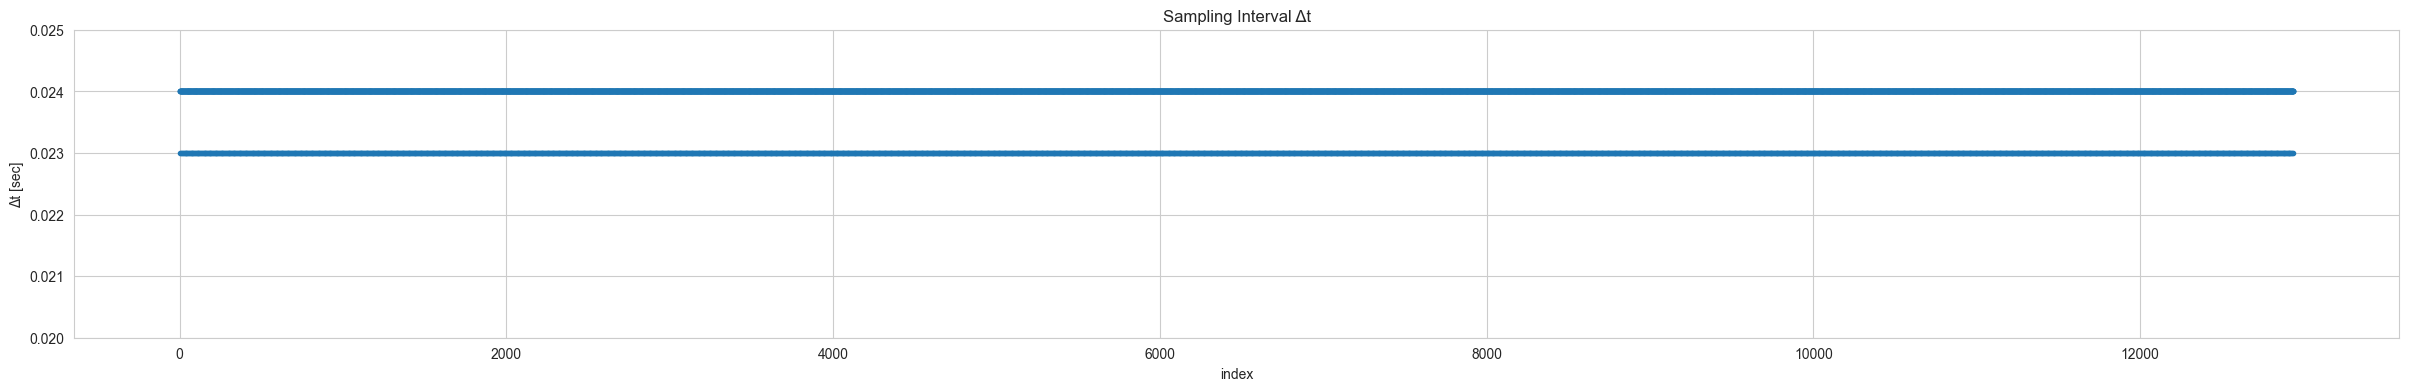

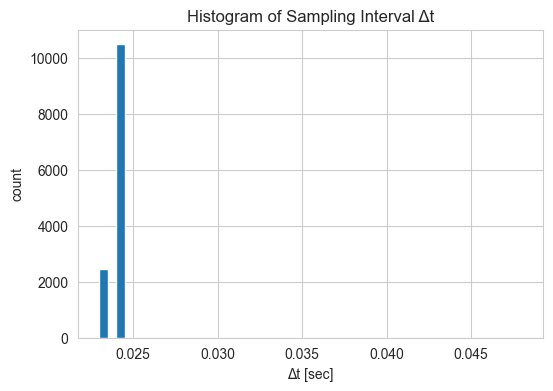

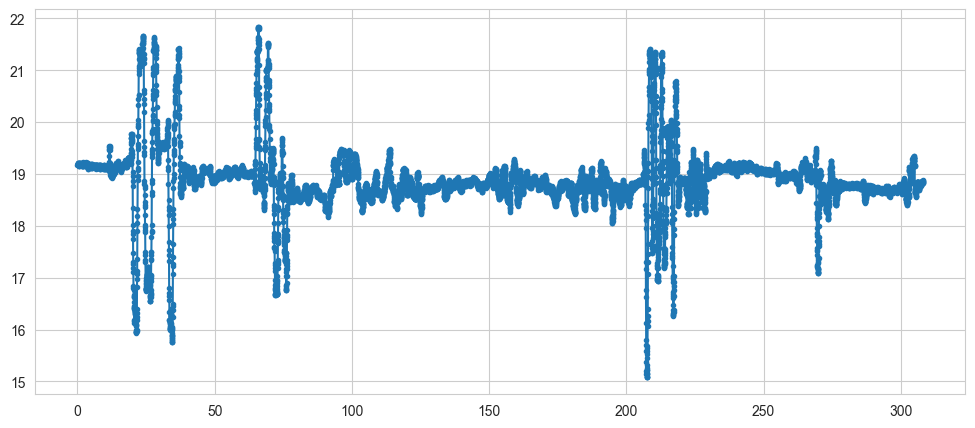

In [32]:
for num, idx in enumerate(data_info.index): 
    row = data_info.iloc[idx,:] 
    sub_ = row['sub'] 
    seat_path = row['seat']
    cop_path = row['cop']
    pedal_path = row['pedal']
    steer_path = row['steer']
    label = row['label']

    if label != "3F":
        continue

    df_seat = pd.read_csv(seat_path,skiprows=1)
    df_cop = pd.read_csv(cop_path,skiprows=21)
    df_pedal = pd.read_csv(pedal_path,skiprows=21)
    df_steer = pd.read_csv(steer_path,skiprows=21)

    if label == "2F":
        df_pedal.rename(columns={'Untitled 1':'pedal'},inplace=True)
        df_steer.rename(columns={'Untitled 1':'steer','Untitled 2':'trg'},inplace=True)
        df_cop.rename( columns={'Untitled 2':'COP_X','Untitled 3':'COP_Y'},inplace=True)

    elif label =="3F":
        df_pedal.rename(columns={'Untitled 4':'pedal','Untitled 5':'trg'},inplace=True)
        df_steer.rename(columns={'Untitled 1':'steer'},inplace=True)
        df_cop.rename(columns={'Untitled':'F1','Untitled 1':'F2','Untitled 2':'F3','Untitled 3':'F4','Untitled 4':'FX','Untitled 5':'FY'},inplace=True)


    df_pedal = make_time_row(df_pedal)
    df_steer = make_time_row(df_steer)
    df_cop = make_time_row(df_cop)
    
    df_mock = pd.merge(df_cop[['time','F1','F2','F3','F4','FX','FY']], df_steer[['time','steer']], on='time', how='left', suffixes=('', '_DROP')).filter(regex='^(?!.*_DROP)') 
    df_mock = pd.merge(df_mock, df_pedal[['time','pedal','trg']], on='time', how='left', suffixes=('', '_DROP')).filter(regex='^(?!.*_DROP)') 


    df_mock_tmp = get_first_trigger_segment(df_mock, trigger_col="trg", trigger_value=1)
    df_mock_tmp['time'] -= df_mock_tmp['time'].iloc[0]
    plt.plot(df_mock_tmp.time,df_mock_tmp['FY'],'-',color='blue')
    plt.plot(df_mock_tmp.time,df_mock_tmp['FX'],'-',color='orange')
    plt.ylim(-0.5,0.5)
    plt.show()

    df_seat = fix_columns(df_seat)
    df_seat['time'] = df_seat['時間_1']
    fs, dt = estimate_sampling_rate(df_seat)
    print("Sampling rate:", fs, "Hz")

    # time 差分（サンプリング間隔）
    dt = df_seat['time'].diff()

    plt.figure(figsize=(30,4))
    plt.plot(dt,'.')
    plt.title("Sampling Interval Δt")
    plt.xlabel("index")
    plt.ylabel("Δt [sec]")
    plt.ylim(0.020,0.025)
    plt.grid(True)
    plt.show()


    plt.figure(figsize=(6,4))
    plt.hist(dt.dropna(), bins=50)
    plt.title("Histogram of Sampling Interval Δt")
    plt.xlabel("Δt [sec]")
    plt.ylabel("count")
    plt.grid(True)
    plt.show()



    plt.plot(df_seat.time,df_seat['圧力中心列_2'],'.-')

    
    # break


--- Processing Start ---
Column 'FX' (Thresh=10.0): Detected 9 outliers.
Column 'FY' (Thresh=1.0): Detected 0 outliers.
--- Processing End ---



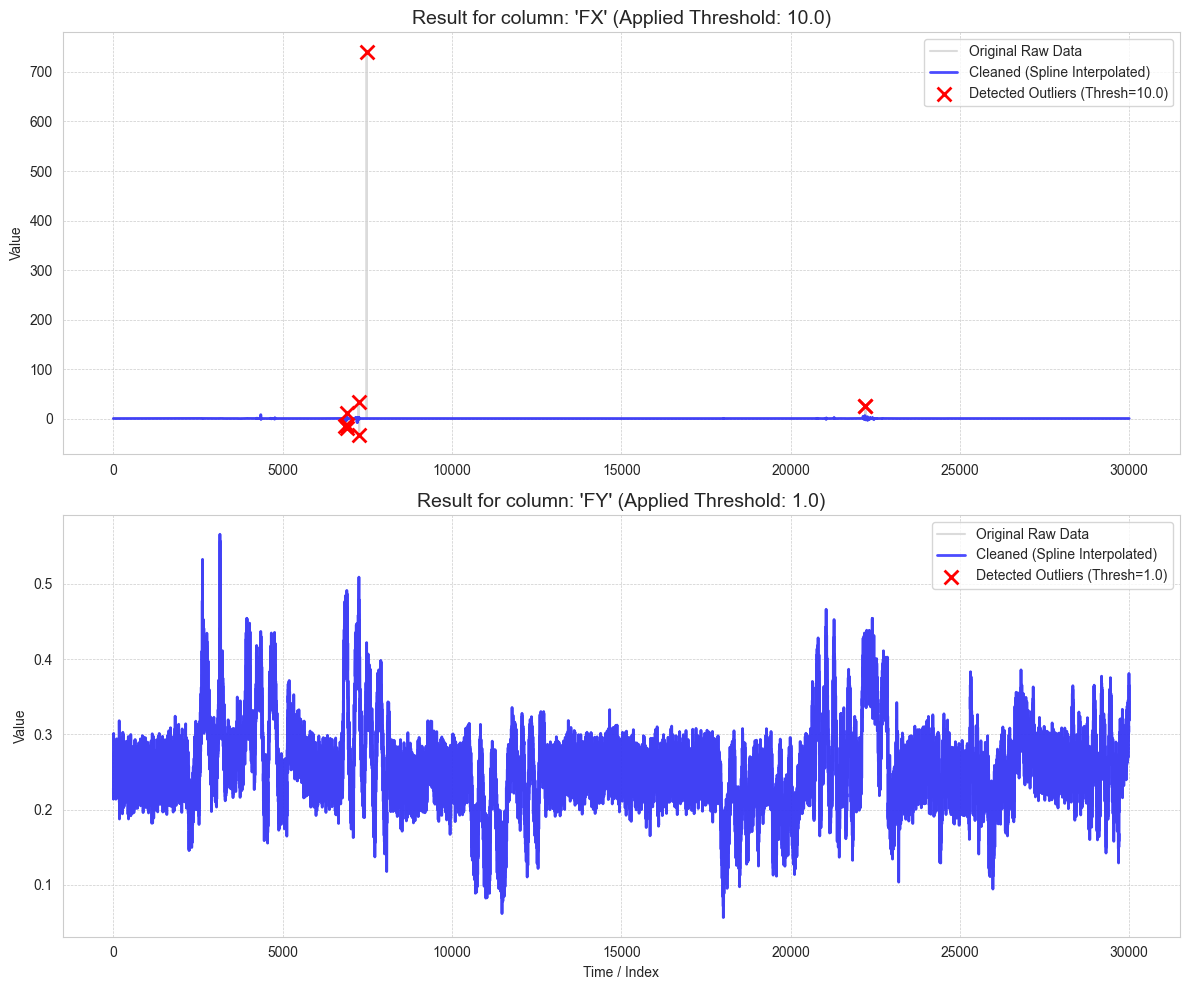

In [38]:
# --- 修正済みの関数 ---
def clean_outliers_spline_multi(df_input, threshold_dict, window=11):
    """
    カラムごとに異なる閾値で外れ値を検知し、スプライン補間で埋める関数。
    (インデックス重複や不整合によるエラーを回避する .values 版)
    """
    # 元データを変更しないようコピー
    df_result = df_input.copy()
    
    for col, thresh in threshold_dict.items():
        if col not in df_result.columns:
            continue

        # 1. トレンド推定（Seriesのまま計算）
        # rollingはインデックスを維持するため、そのまま使います
        rolling_obj = df_result[col].rolling(window=window, center=True)
        rolling_median = rolling_obj.median()
        
        # 2. 残差スコア計算 & 3. 閾値判定
        # 【重要修正ポイント】 .values をつけて Numpy配列同士として計算します。
        # これによりインデックスの不整合によるエラーを回避します。
        diff = df_result[col].values - rolling_median.values
        score = np.abs(diff)
        
        # マスクもNumpy配列(True/Falseのリスト)になります
        outlier_mask = score > thresh
        
        # ログ表示（numpyのsumを使います）
        n_outliers = np.sum(outlier_mask) 
        print(f"Column '{col}' (Thresh={thresh}): Detected {n_outliers} outliers.")
        
        if n_outliers > 0:
            # 4. 外れ値をNaNに置換
            # .loc は Numpy配列のマスク(True/False)をそのまま受け取れます
            df_result.loc[outlier_mask, col] = np.nan
            
            # 5. スプライン補間
            # limit_direction='both'で端も埋めます
            df_result[col] = df_result[col].interpolate(method='spline', order=3, limit_direction='both')
            
    return df_result

# ==========================================
#  実行と確認プロット
# ==========================================

# 1. テスト用データの作成（正常な時系列データ）
# np.random.seed(42)
# t = np.linspace(0, 100, 300) # 点数を少し増やして滑らかに

# # カラムA (FX): 変動が小さいデータ
# col_a = np.sin(t / 5) + np.random.normal(0, 0.1, 300)
# col_a[50] = 4.5   # 上スパイク
# col_a[120] = -3.5 # 下スパイク

# # カラムB (Sensor): 変動が激しいデータ（振幅が大きい）
# col_b = 5 * np.cos(t / 5) + np.random.normal(0, 0.5, 300) 
# col_b[200] = 18.0 # 巨大なスパイク
# col_b[205:210] = -15.0 # 幅のある異常

# df_mock = pd.DataFrame({'FX': col_a, 'Sensor': col_b}, index=t)

# 2. 設定（辞書で閾値を個別指定）
# FXは厳しく(1.0)、Sensorは緩く(4.0)
settings = {
    'FX': 10.0,
    'FY': 1.0 
}

# 3. 関数を実行（修正済み関数を使用）
print("--- Processing Start ---")
df_cleaned = clean_outliers_spline_multi(df_mock, threshold_dict=settings, window=15)
print("--- Processing End ---\n")

# --- 復活させた結果確認プロット ---
fig, axes = plt.subplots(len(settings), 1, figsize=(12, 10))

# 辞書のキー（カラム名）を使って順番にプロット
for i, col in enumerate(settings.keys()):
    # 元データ（薄いグレーで表示）
    axes[i].plot(df_mock.index, df_mock[col], label='Original Raw Data', color='lightgray', alpha=0.8, linewidth=1.5)
    
    # 補間後データ（青色で表示）
    axes[i].plot(df_cleaned.index, df_cleaned[col], label='Cleaned (Spline Interpolated)', color='blue', linewidth=2, alpha=0.7)
    
    # 除去された点（赤いバツ印で強調）
    # 元データと補間後データが異なる場所を探します
    removed_points = df_mock[df_mock[col] != df_cleaned[col]]
    axes[i].scatter(removed_points.index, removed_points[col], color='red', marker='x', s=100, linewidth=2, label=f'Detected Outliers (Thresh={settings[col]})', zorder=5)
    
    # グラフの体裁を整える
    axes[i].set_title(f"Result for column: '{col}' (Applied Threshold: {settings[col]})", fontsize=14)
    axes[i].legend(fontsize=10)
    axes[i].grid(True, which='both', linestyle='--', linewidth=0.5)
    axes[i].set_ylabel('Value')

axes[-1].set_xlabel('Time / Index')
plt.tight_layout()
plt.show()

In [39]:
df_cleaned.columns

Index(['time', 'F1', 'F2', 'F3', 'F4', 'FX', 'FY', 'steer', 'pedal', 'trg'], dtype='object')

# リサンプリング

C:\Users\youli\AppData\Local\Temp\ipykernel_28220\3285634799.py:114: UserWarning: Glyph 12489 (\N{KATAKANA LETTER DO}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\youli\AppData\Local\Temp\ipykernel_28220\3285634799.py:114: UserWarning: Glyph 12522 (\N{KATAKANA LETTER RI}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\youli\AppData\Local\Temp\ipykernel_28220\3285634799.py:114: UserWarning: Glyph 12501 (\N{KATAKANA LETTER HU}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\youli\AppData\Local\Temp\ipykernel_28220\3285634799.py:114: UserWarning: Glyph 12488 (\N{KATAKANA LETTER TO}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\youli\AppData\Local\Temp\ipykernel_28220\3285634799.py:114: UserWarning: Glyph 37327 (\N{CJK UNIFIED IDEOGRAPH-91CF}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\youli\AppData\Local\Temp\ipykernel_28220\3285634799.py:114: UserWarning: Glyph 12469 (\N{KATAKANA LETTER SA}) missing from font(s) Arial.
  plt

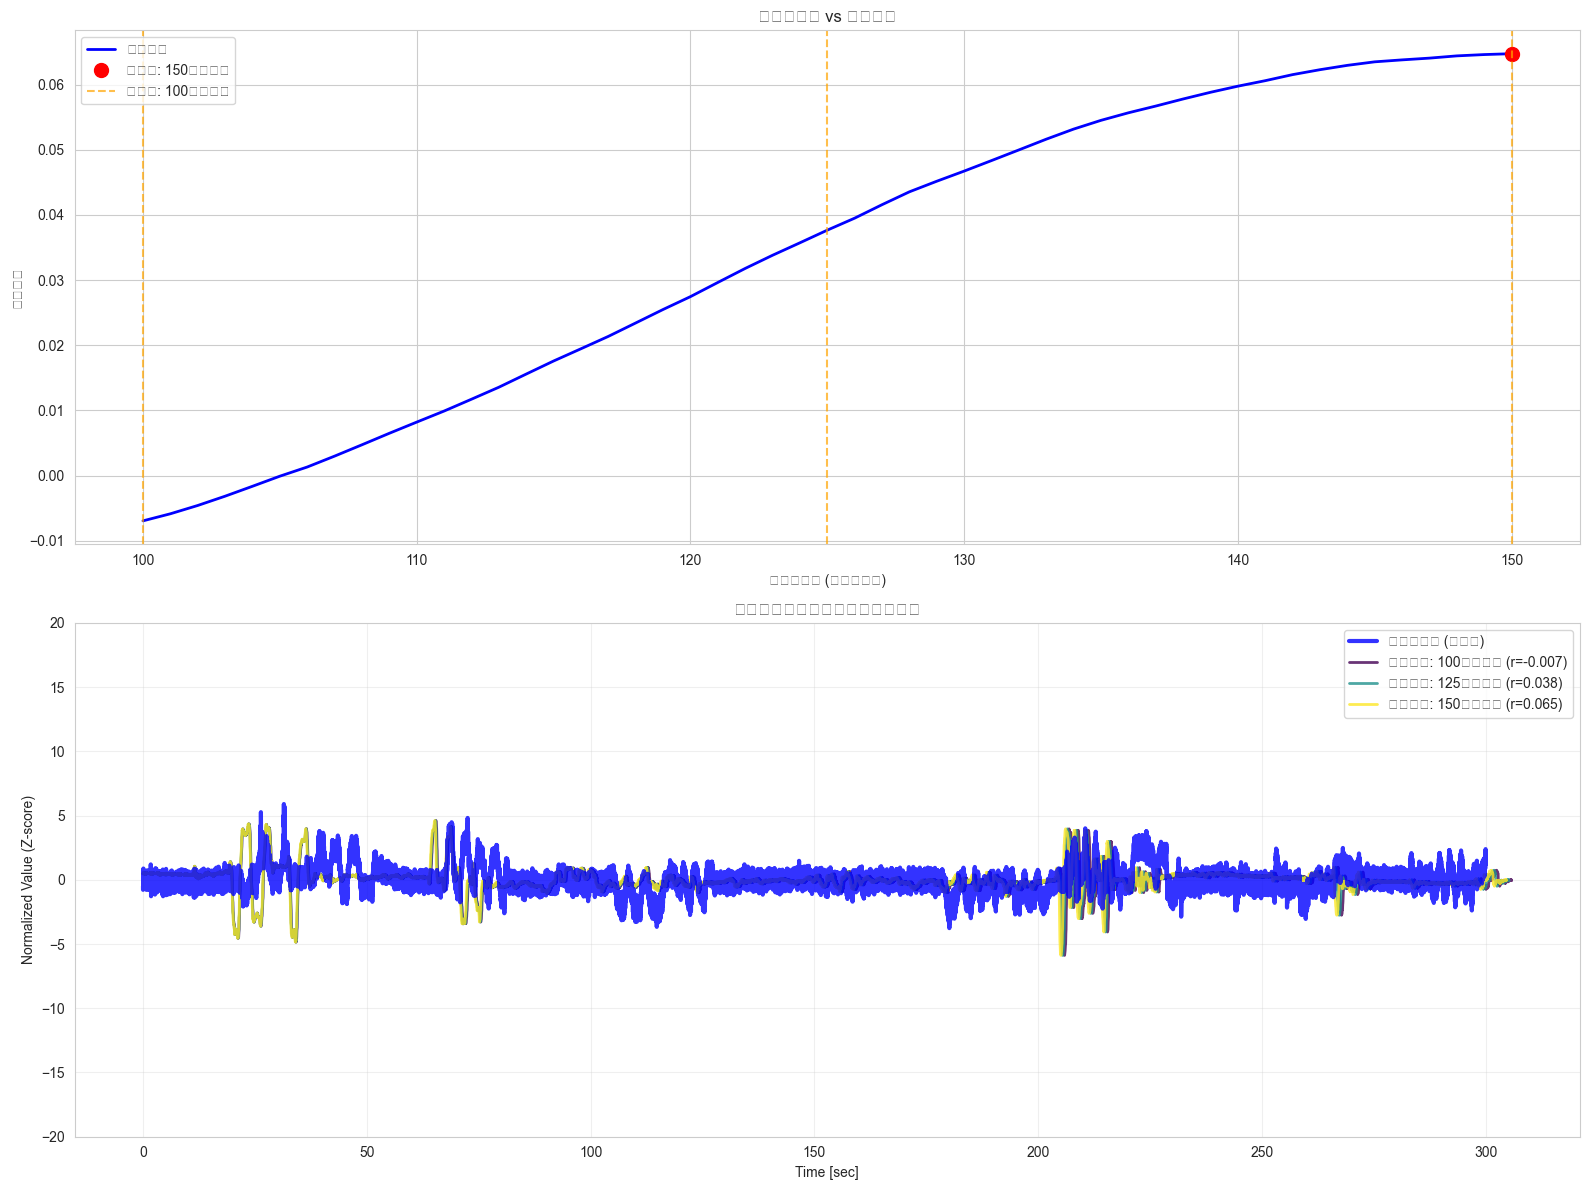


=== 探索結果サマリー ===
探索範囲: 100 ~ 150 サンプル
最適なドリフト量: 150 サンプル
最大相関係数: 0.0647

=== 代表サンプル詳細 ===
   ドリフト 100 サンプル: 相関係数 = -0.0070
   ドリフト 125 サンプル: 相関係数 = 0.0377
★ ドリフト 150 サンプル: 相関係数 = 0.0647


In [53]:
def evaluate_linear_drifts_with_samples(df_ref, df_target, drift_range, 
                                       col_ref='COP_X', col_target='圧力中心列_2',
                                       num_sample_views=3):
    """
    線形ドリフトの評価＋代表的なサンプルを時系列グラフで表示
    """
    
    # --- 1. 前処理: 正規化 ---
    ref_data = df_ref[col_ref]
    ref_norm = (ref_data - ref_data.mean()) / ref_data.std()
    
    target_data = df_target[col_target]
    target_norm = (target_data - target_data.mean()) / target_data.std()
    
    # --- 2. 時間軸計算の準備 ---
    dt_mean = df_target['time'].diff().mean()
    t_start = df_target['time'].min()
    t_end_orig = df_target['time'].max()
    duration = t_end_orig - t_start
    
    # --- 3. 全範囲で相関計算 ---
    all_results = []
    for drift_samples in range(drift_range[0], drift_range[1] + 1):
        total_lag_time = drift_samples * dt_mean
        scale_factor = duration / (duration + total_lag_time)
        new_time = t_start + (df_target['time'] - t_start) * scale_factor
        
        # 補間
        from scipy import interpolate
        f_interp = interpolate.interp1d(new_time, target_norm, 
                                      bounds_error=False, fill_value='extrapolate')
        target_aligned = f_interp(df_ref['time'])
        
        # 相関計算
        valid_mask = ~np.isnan(target_aligned)
        if np.sum(valid_mask) > 10:
            correlation = np.corrcoef(ref_norm[valid_mask], target_aligned[valid_mask])[0,1]
        else:
            correlation = -1
            
        all_results.append((drift_samples, correlation))
    
    # 結果をソート
    all_results.sort(key=lambda x: x[0])
    drifts, corrs = zip(*all_results)
    
    # --- 4. 代表サンプルの選択 ---
    if len(drifts) <= num_sample_views:
        sample_drifts = drifts
    else:
        # 最小、中央、最大から選択
        indices = [
            0,  # 最小
            len(drifts) // 2,  # 中央
            len(drifts) - 1  # 最大
        ]
        sample_drifts = [drifts[i] for i in indices]
    
    # --- 5. 可視化 ---
    fig = plt.figure(figsize=(16, 12))
    
    # 5-1. 相関グラフ
    ax1 = plt.subplot(2, 1, 1)
    best_idx = np.argmax(corrs)
    plt.plot(drifts, corrs, 'b-', linewidth=2, label='相関係数')
    plt.plot(drifts[best_idx], corrs[best_idx], 'ro', markersize=10, 
             label=f'最適点: {drifts[best_idx]}サンプル')
    
    # 代表サンプルを縦線で表示
    for drift in sample_drifts:
        idx = drifts.index(drift)
        plt.axvline(x=drift, color='orange', linestyle='--', alpha=0.7,
                   label=f'代表点: {drift}サンプル' if drift == sample_drifts[0] else "")
    
    plt.xlabel('ドリフト量 (サンプル数)')
    plt.ylabel('相関係数')
    plt.title('ドリフト量 vs 相関係数')
    plt.grid(True)
    plt.legend()
    
    # 5-2. 時系列比較グラフ
    ax2 = plt.subplot(2, 1, 2)
    
    # 参照データ
    plt.plot(df_ref['time'], ref_norm, color='blue', linewidth=3, 
             alpha=0.8, label='参照データ (正規化)', zorder=10)
    
    # カラーマップ
    colors = plt.cm.viridis(np.linspace(0, 1, len(sample_drifts)))
    
    # 各代表サンプルの時系列をプロット
    for i, drift_samples in enumerate(sample_drifts):
        total_lag_time = drift_samples * dt_mean
        scale_factor = duration / (duration + total_lag_time)
        new_time = t_start + (df_target['time'] - t_start) * scale_factor
        
        # このドリフト量での相関係数を検索
        drift_corr = next((corr for drift, corr in all_results if drift == drift_samples), 0)
        
        plt.plot(new_time, target_norm, 
                 color=colors[i], linewidth=2, alpha=0.8,
                 label=f'ドリフト: {drift_samples}サンプル (r={drift_corr:.3f})')
    
    plt.title('代表的なドリフト量の時系列比較')
    plt.xlabel('Time [sec]')
    plt.ylabel('Normalized Value (Z-score)')
    plt.legend(loc='upper right')
    plt.grid(True, alpha=0.3)
    
    # 後半部分を拡大表示
    # plt.xlim(200, 300)
    plt.ylim(-20, 20)
    
    plt.tight_layout()
    plt.show()
    
    # --- 6. 結果表示 ---
    print("\n=== 探索結果サマリー ===")
    print(f"探索範囲: {drift_range[0]} ~ {drift_range[1]} サンプル")
    print(f"最適なドリフト量: {drifts[best_idx]} サンプル")
    print(f"最大相関係数: {corrs[best_idx]:.4f}")
    
    print(f"\n=== 代表サンプル詳細 ===")
    for drift in sample_drifts:
        idx = drifts.index(drift)
        marker = "★" if drift == drifts[best_idx] else "  "
        print(f"{marker} ドリフト {drift:3d} サンプル: 相関係数 = {corrs[idx]:.4f}")
    
    return all_results, sample_drifts

# ==========================================
# 実行例
# ==========================================

# 広い範囲で探索し、代表3点を可視化
all_results, sample_drifts = evaluate_linear_drifts_with_samples(
    # df_mock_tmp, 
    df_cleaned,
    df_seat, 
    drift_range=[100, 150],  # 探索範囲
    # col_ref='FX', 
    # col_target='圧力中心行_1',
    # col_ref='FX', 
    # col_target='圧力中心行_2',
    # col_ref='FY', 
    # col_target='圧力中心列_1',
    col_ref='FY', 
    col_target='圧力中心列_2',
    num_sample_views=3  # 表示する代表点の数
)

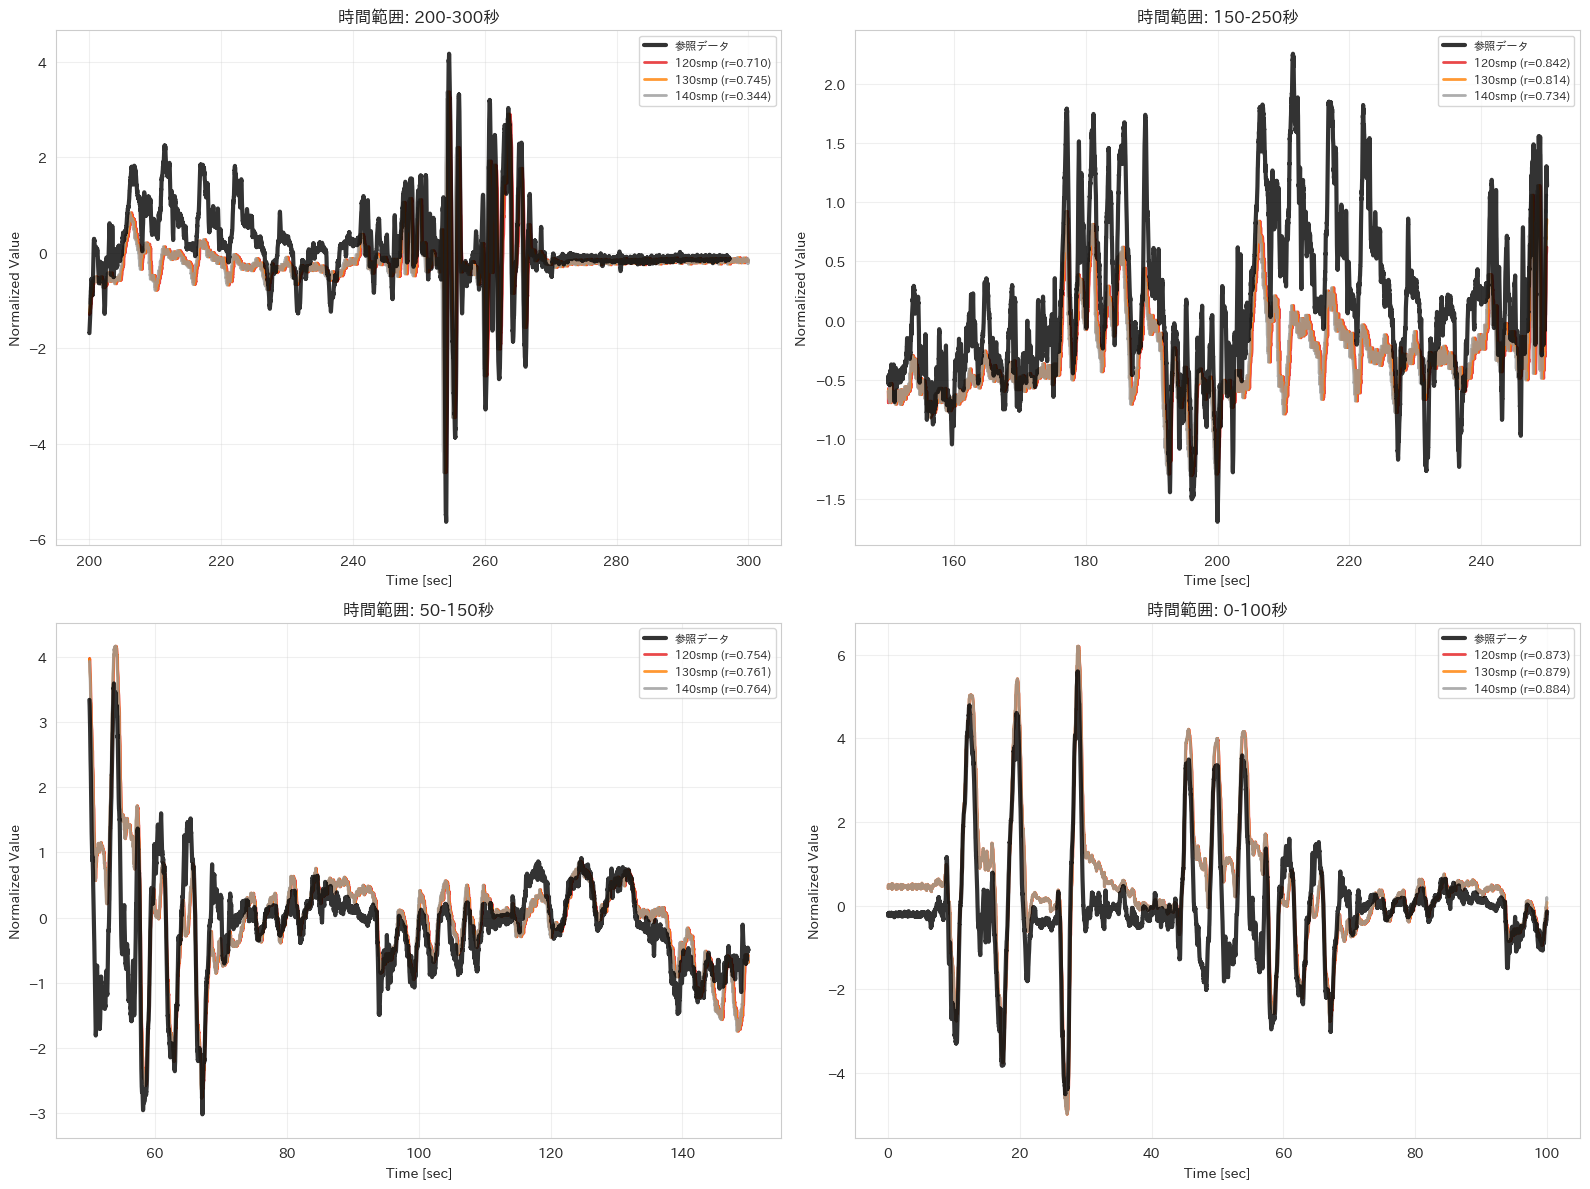


=== 指定ドリフト量の全体相関 ===
ドリフト 120 サンプル: 全体相関 = 0.7789
ドリフト 130 サンプル: 全体相関 = 0.7887
ドリフト 140 サンプル: 全体相関 = 0.7208


In [7]:
def compare_detailed_samples(df_ref, df_target, specific_drifts, 
                           col_ref='COP_X', col_target='圧力中心列_2',
                           focus_range=(200, 300)):
    """
    特定のドリフト量を詳細に比較（複数区間で表示）
    """
    
    # --- 前処理 ---
    ref_data = df_ref[col_ref]
    ref_norm = (ref_data - ref_data.mean()) / ref_data.std()
    
    target_data = df_target[col_target]
    target_norm = (target_data - target_data.mean()) / target_data.std()
    
    dt_mean = df_target['time'].diff().mean()
    t_start = df_target['time'].min()
    t_end_orig = df_target['time'].max()
    duration = t_end_orig - t_start
    
    # --- 複数サブプロットで表示 ---
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    axes = axes.flatten()
    
    # カラーマップ
    colors = plt.cm.Set1(np.linspace(0, 1, len(specific_drifts)))
    
    # 各注目区間をプロット
    focus_ranges = [
        (200, 300),  # 後半部分
        (150, 250),  # 中間部分
        (50, 150),   # 前半部分
        (0, 100)     # 最初の部分
    ]
    
    for ax_idx, (start_time, end_time) in enumerate(focus_ranges):
        if ax_idx >= len(axes):
            break
            
        ax = axes[ax_idx]
        
        # 参照データ
        mask_ref = (df_ref['time'] >= start_time) & (df_ref['time'] <= end_time)
        ax.plot(df_ref['time'][mask_ref], ref_norm[mask_ref], 
                color='black', linewidth=3, alpha=0.8, 
                label='参照データ', zorder=10)
        
        # 各ドリフト量
        for i, drift_samples in enumerate(specific_drifts):
            total_lag_time = drift_samples * dt_mean
            scale_factor = duration / (duration + total_lag_time)
            new_time = t_start + (df_target['time'] - t_start) * scale_factor
            
            # 相関係数計算（この区間のみ）
            mask_target = (new_time >= start_time) & (new_time <= end_time)
            if np.sum(mask_target) > 5:
                # この区間内での相関を計算
                time_in_range = new_time[mask_target]
                values_in_range = target_norm[mask_target]
                
                # 参照データと同じ時間点に補間
                from scipy import interpolate
                f_interp = interpolate.interp1d(time_in_range, values_in_range, 
                                              bounds_error=False, fill_value='extrapolate')
                target_aligned = f_interp(df_ref['time'][mask_ref])
                
                # 相関計算
                valid_mask = ~np.isnan(target_aligned)
                if np.sum(valid_mask) > 5:
                    correlation = np.corrcoef(ref_norm[mask_ref][valid_mask], 
                                            target_aligned[valid_mask])[0,1]
                else:
                    correlation = 0
            else:
                correlation = 0
            
            # プロット
            ax.plot(new_time[mask_target], target_norm[mask_target],
                   color=colors[i], linewidth=2, alpha=0.8,
                   label=f'{drift_samples}smp (r={correlation:.3f})')
        
        ax.set_title(f'時間範囲: {start_time}-{end_time}秒')
        ax.set_xlabel('Time [sec]')
        ax.set_ylabel('Normalized Value')
        ax.grid(True, alpha=0.3)
        ax.legend(fontsize=8)
    
    plt.tight_layout()
    plt.show()
    
    # 各ドリフト量の全体相関も表示
    print("\n=== 指定ドリフト量の全体相関 ===")
    for drift_samples in specific_drifts:
        total_lag_time = drift_samples * dt_mean
        scale_factor = duration / (duration + total_lag_time)
        new_time = t_start + (df_target['time'] - t_start) * scale_factor
        
        # 補間
        from scipy import interpolate
        f_interp = interpolate.interp1d(new_time, target_norm, 
                                      bounds_error=False, fill_value='extrapolate')
        target_aligned = f_interp(df_ref['time'])
        
        # 全体相関
        valid_mask = ~np.isnan(target_aligned)
        if np.sum(valid_mask) > 10:
            overall_correlation = np.corrcoef(ref_norm[valid_mask], target_aligned[valid_mask])[0,1]
            print(f"ドリフト {drift_samples:3d} サンプル: 全体相関 = {overall_correlation:.4f}")

# 特定のドリフト量を詳細比較
compare_detailed_samples(
    df_mock_tmp, 
    df_seat, 
    specific_drifts=[120, 130, 140],  # 比較したい特定の値
    col_ref='COP_X', 
    col_target='圧力中心列_2'
)

補正情報:
  - ズレサンプル数: 126
  - ズレ時間換算  : 3.0002 sec
  - 適用スケール  : 0.99049845


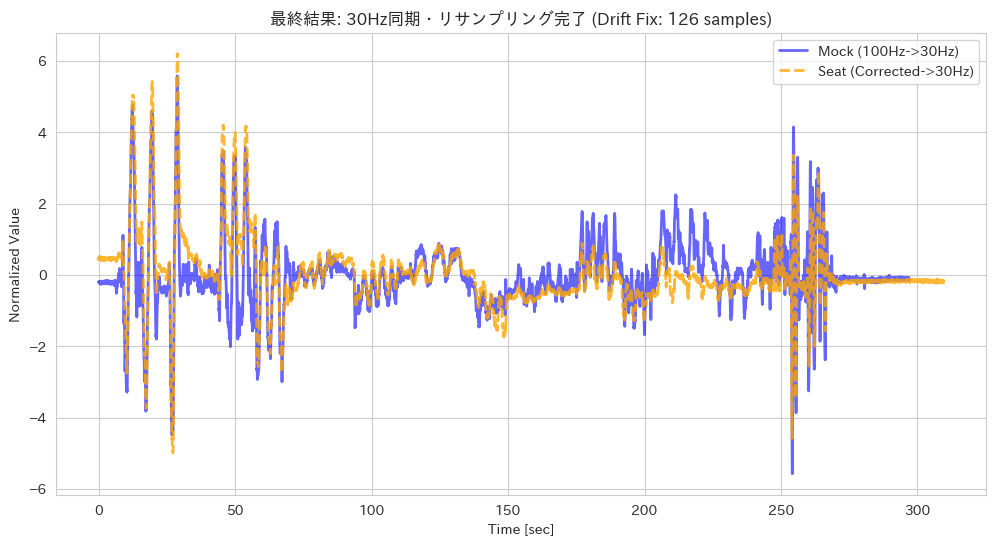

--- df_mock_30hz ---
       time     COP_X     COP_Y     steer       trg     pedal
0  0.000000  0.011814 -0.021516 -0.565450  5.055610  0.375131
1  0.033333  0.011866 -0.022303 -0.563513  5.055717  0.375783
2  0.066667  0.011679 -0.021782 -0.564624  5.055546  0.376217
3  0.100000  0.011824 -0.022071 -0.567672  0.000025  0.375131
4  0.133333  0.011552 -0.021779 -0.568205  0.000017  0.375131

--- df_seat_30hz ---
       time  平均圧力_1  最低圧力_1   ピーク圧力_1  接触域 (cm²)_1  選択領域(cm²)_1     接触 %_1  \
0  0.000000    0.32    0.13  1.320000  1051.610000      2580.65  40.750000   
1  0.033333    0.32    0.13  1.321956  1053.540855      2580.65  40.827712   
2  0.066667    0.32    0.13  1.326788  1051.610000      2580.65  40.750000   
3  0.100000    0.32    0.13  1.345034  1060.487982      2580.65  41.097721   
4  0.133333    0.32    0.13  1.323495  1062.262327      2580.65  41.162629   

      荷重(N)_1  標準偏差_1  平均_1  ...  最低圧力_2   ピーク圧力_2  接触域 (cm²)_2  選択領域(cm²)_2  \
0  337.820000    0.21   0.3  ...    

In [8]:


# =========================================================
# 1. パラメータ設定
# =========================================================
BEST_DRIFT_SAMPLES = 126  # 見つけたベストな値
TARGET_FS = 30.0           # 目標サンプリング周波数 (Hz)

# =========================================================
# 2. df_seat の時間軸を補正（永続化）
# =========================================================
def apply_drift_correction(df, drift_samples):
    """
    見つけたドリフト量(samples)に基づいて時間軸を実際に書き換える
    """
    df_fixed = df.copy()
    
    # 統計量の計算
    dt_mean = df_fixed['time'].diff().mean()
    t_start = df_fixed['time'].min()
    t_end   = df_fixed['time'].max()
    duration = t_end - t_start
    
    # ズレ時間の計算 (35サンプル * 1サンプルの時間)
    total_lag_time = drift_samples * dt_mean
    
    # 伸縮率 (Scale Factor) の計算
    # visualize関数と同じ計算式を使用
    scale_factor = duration / (duration + total_lag_time)
    
    print(f"補正情報:")
    print(f"  - ズレサンプル数: {drift_samples}")
    print(f"  - ズレ時間換算  : {total_lag_time:.4f} sec")
    print(f"  - 適用スケール  : {scale_factor:.8f}")
    
    # 時間軸の更新
    df_fixed['time'] = t_start + (df_fixed['time'] - t_start) * scale_factor
    
    return df_fixed

# df_seat の時間を修正
df_seat_fixed = apply_drift_correction(df_seat, BEST_DRIFT_SAMPLES)


# =========================================================
# 3. 共通の30Hzへのリサンプリング
# =========================================================
def resample_to_target_hz(df, time_col, data_cols, target_fs):
    """
    指定されたDataFrameをtarget_fs(Hz)にリサンプリングする関数
    """
    # 元データ
    t_src = df[time_col].values
    # 時間軸の開始と終了（データの範囲内）
    t_min, t_max = t_src.min(), t_src.max()
    
    # 新しい時間軸 (startからendまで 1/fs 刻み)
    new_time = np.arange(t_min, t_max, 1.0 / target_fs)
    
    # 結果格納用DataFrame
    df_resampled = pd.DataFrame({time_col: new_time})
    
    # 指定されたデータ列を補間
    for col in data_cols:
        # 線形補間 (linear) または 3次スプライン (cubic)
        f = interpolate.interp1d(t_src, df[col].values, kind='linear', fill_value="extrapolate")
        df_resampled[col] = f(new_time)
        
    return df_resampled

# --- リサンプリング実行 ---

mock_cols = ['COP_X', 'COP_Y', 'steer', 'trg', 'pedal']
seat_cols = ['平均圧力_1', '最低圧力_1',
       'ピーク圧力_1', '接触域 (cm²)_1', '選択領域(cm²)_1', '接触 %_1', '荷重(N)_1', '標準偏差_1',
       '平均_1', '圧力中心行_1', '圧力中心列_1', '平均圧力_2', '最低圧力_2', 'ピーク圧力_2',
       '接触域 (cm²)_2', '選択領域(cm²)_2', '接触 %_2', '荷重(N)_2', '標準偏差_2', '平均_2',
       '圧力中心行_2', '圧力中心列_2']

# df_mock_tmp (元100Hz) -> 30Hz
df_mock_30hz = resample_to_target_hz(
    df_mock_tmp, 
    time_col='time', 
    data_cols=mock_cols, # 必要な列を指定
    target_fs=TARGET_FS
)

# df_seat_fixed (補正済み40Hz) -> 30Hz
df_seat_30hz = resample_to_target_hz(
    df_seat_fixed, 
    time_col='time', 
    data_cols=seat_cols, # 必要な列を指定
    target_fs=TARGET_FS
)


# =========================================================
# 4. 結果の確認（結合・プロット）
# =========================================================

# 時間軸を完全に合わせるため、共通の時間範囲でデータを結合（Merge）しても良いですが、
# ここではプロットで確認します。

# 正規化関数（比較用）
def z_score(series):
    return (series - series.mean()) / series.std()

plt.figure(figsize=(12, 6))

# 青: df_mock (30Hz)
plt.plot(df_mock_30hz['time'], z_score(df_mock_30hz['COP_X']), 
         label='Mock (100Hz->30Hz)', color='blue', alpha=0.6, linewidth=2)

# オレンジ: df_seat (補正済み->30Hz)
plt.plot(df_seat_30hz['time'], z_score(df_seat_30hz['圧力中心列_2']), 
         label='Seat (Corrected->30Hz)', color='orange', alpha=0.8, linestyle='--', linewidth=2)

plt.title(f"最終結果: 30Hz同期・リサンプリング完了 (Drift Fix: {BEST_DRIFT_SAMPLES} samples)")
plt.xlabel("Time [sec]")
plt.ylabel("Normalized Value")
plt.legend()
plt.grid(True)

# ズレやすい後半を拡大
t_end = df_mock_30hz['time'].max()
# plt.xlim(t_end - 10, t_end) 

plt.show()

# データフレームの中身確認
print("--- df_mock_30hz ---")
print(df_mock_30hz.head())
print("\n--- df_seat_30hz ---")
print(df_seat_30hz.head())

Step 2: モデルA（モドキCOP $X$ → 重要特徴量 $Y$） の構築に着手しましょう。ここでは、「4つの荷重センサの値」 から、** 先ほどの分析で重要と判明した **  「シート圧センサの特定の統計量（列座標、荷重、行座標）」 を、PLS回帰を用いて予測します。

## PLSを推奨する理由：
一言で言えば、**「入力センサ同士の相関（被り）を利用して、ノイズを消しつつ信号を取り出すのに最強だから」**です。

推奨理由 1：多重共線性（Multicollinearity）への強さ状況: 4つの荷重センサ（左前、右前、左後、右後）は独立していません。
* 例：人が「右」に傾いたとき、「右前」と「右後」は同時に増え、「左前」と「左後」は同時に減ります。<br>
* 問題点: 通常の回帰分析（重回帰）は、このように「連動する（相関が高い）入力変数」が入ってくると、計算が不安定になり、係数がめちゃくちゃな値（プラスマイナス逆転など）になります。<br>
* PLSの解決策:PLSは、4つのセンサの値をそのまま使うのではなく、「要するに右に傾いている」という新しい変数（潜在変数 / 成分） を内部で作ってから回帰します。これにより、センサ同士の相関をプラスの情報として活用できます。<br>

推奨理由 2：PCA（主成分分析）よりも「予測」に特化している「変数を圧縮するならPCAでいいのでは？」と思うかもしれません。しかし、PCAとPLSには決定的な違いがあります。
* PCA + 回帰:$X$ の中で「ばらつきが大きい方向」を探します。
  * 欠点: もし「ノイズのばらつき」が大きくても、PCAはそれを重要な情報だと勘違いします。$Y$ と関係ない変動を拾ってしまうリスクがあります。
* PLS 回帰:$X$ の中で**「$Y$ との相関（共分散）が最大になる方向」**を探します。
  * 利点: 「$Y$（シート圧の動き）を説明するのに役立つ成分だけ」を $X$ から抽出します。センサのノイズを除去し、純粋な信号だけを取り出せます。<br>

推奨理由 3：多目的変数（Multi-output）の同時予測状況: 今回のターゲット $Y$ は複数あります（圧力中心列、荷重、圧力中心行など）。これらはバラバラに動くのではなく、「体が前に倒れたら、荷重が増えて、行座標も動く」というように連動しています。
* Ridgeの場合: 通常、$Y_1, Y_2, Y_3...$ それぞれに対して別々のモデルを作ります（連動性を無視する）。
* PLSの場合: 複数の $Y$ をまとめて一つのモデルで学習します。「$X$ のこのパターンが出たら、$Y$ 全体がこう動く」という構造を捉えるため、個別に予測するよりも整合性の取れた結果が出やすくなります。



## なぜ Model A でこれらを選ぶのか？（選択と集中）<br>
これから作る Model A（モドキCOP $X$ → シート圧 $Y$）の目的は、あくまで「最終的に $Z$ を当てること」です。もし、$Z$ の予測に全く関係ない $Y$（例えば 最低圧力 や 選択領域）を一生懸命予測しても、最終精度は上がりません（無駄な努力になります）。逆に、$Z$ の予測に直結する 「列座標」や「荷重」さえ正確に予測できれば、他の $Y$ がデタラメでも、最終的な $Z$ の精度は高くなります。したがって、Model A の学習ターゲットは、**「精鋭メンバー」**に絞るべきです。

In [ ]:

# --- Cell 10: Model A (PLS Regression) Setup & Optimization ---
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# ==========================================
# 【重要】列名の設定エリア
# ==========================================

# 1. 入力 X: モドキセンサ（4つの荷重センサ）の列名
# ※ データセットにある実際の列名に書き換えてください
# 例: ['Sensor_FL', 'Sensor_FR', 'Sensor_RL', 'Sensor_RR']
mock_sensor_cols = ['荷重1', '荷重2', '荷重3', '荷重4', 'pedal','steer'] 

# 2. 出力 Y: モデルBで「重要」と判明した特徴量 (ターゲット)
# ※ 先ほどの分析結果に基づき、以下の3〜4つを推奨します
target_features_A = [
    '圧力中心列_2', # COP X (左右) に最も効く
    '荷重(N)_1',    # COP Y (前後) に最も効く
    '圧力中心行_1', # COP Y の補正に効く
    '圧力中心列_1'  # 左右のバランス補正
]

# --- データの準備 ---
# 列が存在するかチェック
available_cols = df_all.columns.tolist()
X_cols = [c for c in mock_sensor_cols if c in available_cols]
Y_cols = [c for c in target_features_A if c in available_cols]

print(f"入力変数(X): {X_cols}")
print(f"出力変数(Y): {Y_cols}")

if len(X_cols) == 0:
    raise ValueError("エラー: モドキセンサの列が見つかりません。列名を修正してください。")

# NaNを含む行を削除してデータセットAを作成
df_A = df_all[X_cols + Y_cols].dropna()
X_A = df_A[X_cols]
Y_A = df_A[Y_cols]

# ==========================================
# 最適な成分数 (n_components) の探索
# ==========================================
# 入力が4次元なので、成分数は 1, 2, 3, 4 のいずれかになります
components_range = range(1, len(X_cols) + 1)
scores = []

# TimeSeriesSplitで評価
tscv = TimeSeriesSplit(n_splits=5)

print("\n--- PLS Component Optimization ---")
for n in components_range:
    pls = PLSRegression(n_components=n)
    # cross_val_scoreはデフォルトでR2を返します
    cv_scores = cross_val_score(pls, X_A, Y_A, cv=tscv, scoring='r2')
    mean_score = np.mean(cv_scores)
    scores.append(mean_score)
    print(f"Components: {n} | Mean R2: {mean_score:.4f}")

best_n = components_range[np.argmax(scores)]
print(f"★ 推奨コンポーネント数: {best_n}")

# ==========================================
# 最適モデルでの学習と可視化
# ==========================================
# 推奨コンポーネント数でモデルを確定
final_pls = PLSRegression(n_components=best_n)

# 最後の1区間をテストとして可視化（時系列分割の最後）
train_idx, test_idx = list(tscv.split(X_A))[-1]
X_train, X_test = X_A.iloc[train_idx], X_A.iloc[test_idx]
Y_train, Y_test = Y_A.iloc[train_idx], Y_A.iloc[test_idx]

final_pls.fit(X_train, Y_train)
Y_pred = final_pls.predict(X_test)

# 結果プロット (最初のターゲット変数を表示)
target_idx = 0 # 0番目のターゲット (例: 圧力中心列_2)
col_name = Y_cols[target_idx]

plt.figure(figsize=(12, 5))
plt.plot(Y_test.values[:, target_idx], label=f'True {col_name}', color='black', alpha=0.6)
plt.plot(Y_pred[:, target_idx], label=f'Pred {col_name}', color='green', linestyle='--', alpha=0.8)
plt.title(f"Model A Prediction (Mock -> {col_name}) | Components={best_n}")
plt.legend()
plt.grid(True)
plt.show()

# 全ターゲットのスコア表示
print("\n--- Final Test Scores (Last Fold) ---")
for i, col in enumerate(Y_cols):
    r2 = r2_score(Y_test.iloc[:, i], Y_pred[:, i])
    print(f"{col:15s}: R2 = {r2:.4f}")

NameError: name 'df_all' is not defined

このコードで確認すること推奨コンポーネント数:おそらく 2 または 3 になるはずです。もし 4 が選ばれた場合、ノイズ除去があまり効いていない（生の情報を全部使ったほうが良い）状態ですが、それでもPLSを使うメリット（多目的変数の同時学習）はあります。R2スコア:ここで $R^2 > 0.8$ 程度出ていれば、「安価なセンサでも、シート圧センサの代わりが務まる」ことの証明になります。特に 圧力中心列（左右） と 荷重（前後） の精度に注目してください。実行結果が出ましたら教えてください。もし精度が低い場合、**「センサ配置の問題」や「非線形性の考慮（入力の2乗項を追加する）」**などの対策を提案します。